# Patient calibration workflow using AutoEmulate

## Introduction


## The Nagavi model

<!-- <b>In this workflow we demonstrate the integration of a Cardiovascular simulator, Naghavi Model from ModularCirc in an end-to-end AutoEmulate workflow.</b>  -->

The Nagavi lumped parameter model is a mathematical model of the human cardiovascular system, designed to simulate the dynamics of blood flow and pressure throughout the heart and circulatory system using lumped parameter modeling. 
A **lumped parameter model** simplifies the cardiovascular system by dividing it into compartments (or "lumps") such as:

- Heart chambers (left and right atria and ventricles)
- Major blood vessels (aorta, vena cava, pulmonary arteries and veins)
- Systemic and pulmonary circulations

Each compartment is modeled using analogies to electrical circuits:

- Pressure ↔ Voltage
- Flow ↔ Current
- Resistance ↔ Vascular resistance (R\)
- Compliance ↔ Vessel elasticity or capacitance (C\)
- Inertance ↔ Blood inertia (L)

This approach allows simulation of the time-dependent relationships between pressure, volume, and flow rate across the entire cardiovascular system using ordinary differential equations (ODEs).

The Nagavi lumped parameter model is a mathematical model of the human cardiovascular system, designed to simulate the dynamics of blood flow and pressure throughout the heart and circulatory system using lumped parameter modeling. 
A **lumped parameter model** simplifies the cardiovascular system by dividing it into compartments (or "lumps") such as:

## Patient calibration workflow

In this tutorial, we present a three-stage workflow for calibrating the Nagavi model to patient-specific clinical data using AutoEmulate. The process has the following stages:

- First we perform a global sensitivity analysis, which identifies the most influential parameters affecting model outputs and reduces the dimensionality of the calibration problem. 
- Next, we apply history matching, a sequential uncertainty quantification technique that uses emulators to efficiently rule out implausible regions of the parameter space based on observed patient data. This results in a restricted, plausible region—known as the NROY (Not Ruled Out Yet) space—where parameters are consistent with the clinical measurements within acceptable uncertainty bounds. 
- Finally, we perform Bayesian inference within this NROY region to estimate the full posterior distribution of the remaining parameters, capturing the most likely values and their associated uncertainty. 

### Global sensitivity analysis

The Nagavi model has 16 parameters which makes individual patient calibration challenging. To address this we use a emulator-based global sensitivity analysis to quantify the influence each parameter on features derived from left ventricle artery pressure. This approach reduces the parameters that will be used in model personalization from 16 to 5.

In [1]:
import pandas as pd
import torch

#### Set up simulator and generate data

For this tutorial we use `ModularCirc` a package that providse a framework for building 0D models and simulating cardiovascular flow and mechanics. The `NaghaviSimulator` simulates pressure traces, we then choose to output summary statistics for each of the simulated traces.

In [2]:
from cardiac_simulator import NaghaviSimulator

simulator = NaghaviSimulator(
    output_variables=['lv.P'],  # We simulate the left ventricle pressure, flow and volume traces
    n_cycles=300, 
    dt=0.001,
)

The simulator comes with predefined input parameters ranges. 

In [3]:
simulator.parameters_range

{'ao.r': (195.0, 325.0),
 'ao.c': (0.22499999999999998, 0.375),
 'art.r': (843.75, 1406.25),
 'art.c': (2.25, 3.75),
 'ven.r': (6.75, 11.25),
 'ven.c': (84.975, 141.625),
 'av.r': (4.5, 7.5),
 'mv.r': (3.0749999999999997, 5.125),
 'la.E_pas': (0.22499999999999998, 0.375),
 'la.E_act': (0.41250000000000003, 0.6875),
 'la.v_ref': (6.75, 11.25),
 'la.k_pas': (0.01665, 0.07500000000000001),
 'lv.E_pas': (0.75, 1.25),
 'lv.E_act': (2.25, 3.75),
 'lv.v_ref': (7.5, 12.5),
 'lv.k_pas': (0.00999, 0.045)}

We can sample from those using Latin Hypercube Sampling to generate data to train the emulator with.

In [4]:
N_samples = 1024
x = simulator.sample_inputs(N_samples,random_seed=42)

We can now use the simulator to generate predictions for the sampled parameters. Alternatively, for convenience. we can load already simulated data.

In [5]:
import os
save = True

if not os.path.exists(f'simulator_results_{N_samples}.csv'):
    # Run batch simulations with the samples generated in Cell 1
    y, x = simulator.forward_batch_skip_failures(x)
    
    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(y)
    inputs_df = pd.DataFrame(x)
    
    if save:
        # Save the results to a CSV file
        results_df.to_csv(f'simulator_results_{N_samples}.csv', index=False)
        inputs_df.to_csv(f'simulator_inputs_{N_samples}.csv', index=False)

else:
    # Read the results from the CSV file
    results_df = pd.read_csv(f'simulator_results_{N_samples}.csv')
    inputs_df = pd.read_csv(f'simulator_inputs_{N_samples}.csv')

    y = torch.tensor(results_df.to_numpy())
    x = torch.tensor(inputs_df.to_numpy())

These are the output summary variables we've simulated.

In [6]:
simulator.output_names

['lv.P_min', 'lv.P_max', 'lv.P_mean', 'lv.P_range']

#### Train emulator with AutoEmulate
 
To perform sensitivity analysis efficiently, we first need to construct an emulator—a fast, surrogate model that approximates the output of the full simulator. The simulated inputs and outputs from the cell above are  used to train the emulator, in this case we choose to use neural networks.

In [7]:
from autoemulate.core.compare import AutoEmulate

from autoemulate.emulators.nn.mlp import MLP

ae = AutoEmulate(
    x, 
    y, 
    models=[MLP],  
    model_tuning=True
)

Comparing models: 100%|██████████| 1.00/1.00 [02:16<00:00, 137s/model]


In [8]:
ae.summarise()

,model_name,x_transforms,y_transforms,params,rmse_test,r2_test,r2_test_std,r2_train,r2_train_std
0,MLP,[StandardizeTransform()],[StandardizeTransform()],"{'epochs': 200, 'layer_dims': [64, 32, 16], 'l...",1.331912,0.84246,0.080731,0.989907,0.021322


Extract the best performing emulator.

In [9]:
model = ae.best_result().model

#### Run Sensitivity Analysis 

The emulator trained above can predict model outputs rapidly across the entire parameter space, allowing us to estimate global sensitivity measures like Sobol’ indices or Morris elementary effects without repeatedly calling the full simulator. This approach enables scalable and accurate sensitivity analysis, especially in high-dimensional or computationally intensive settings.

Here we use AutoEmulate to perform sensitivity analysis. 

In [10]:
from autoemulate.core.sensitivity_analysis import SensitivityAnalysis

# Define the problem dictionary for Sobol sensitivity analysis
problem = {
    'num_vars': simulator.in_dim,
    'names': simulator.param_names,
    'bounds': simulator.param_bounds
}

si = SensitivityAnalysis(model, problem=problem)

In [11]:
si_df = si.run(method='sobol')


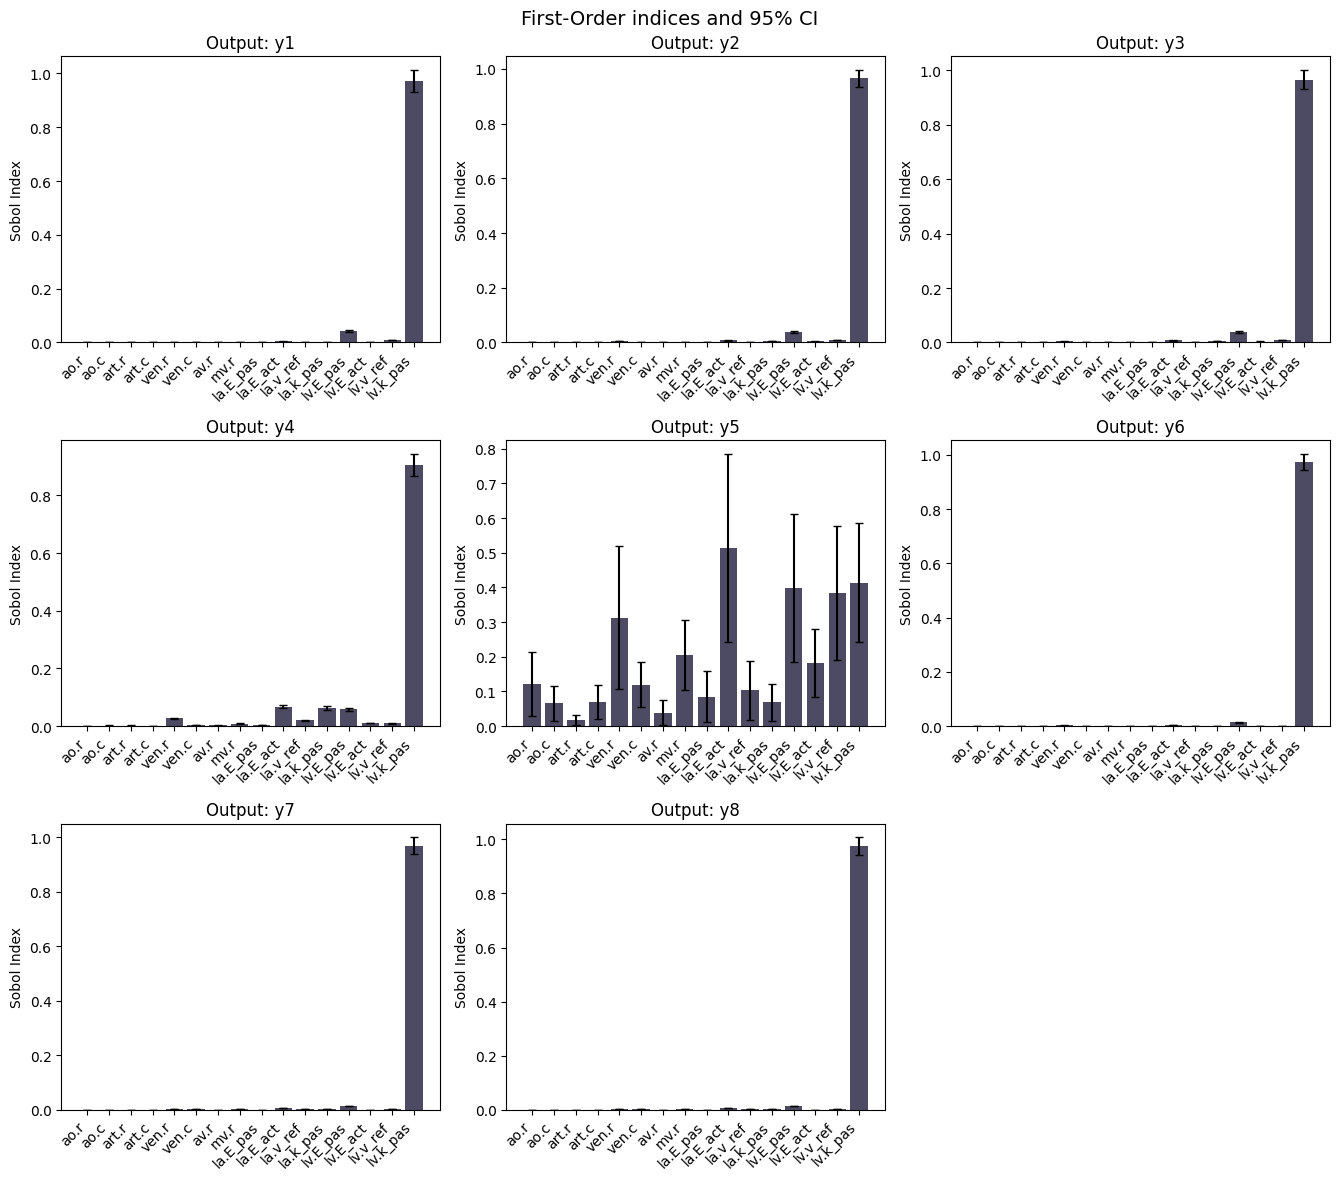

In [12]:
si.plot_sobol(si_df)

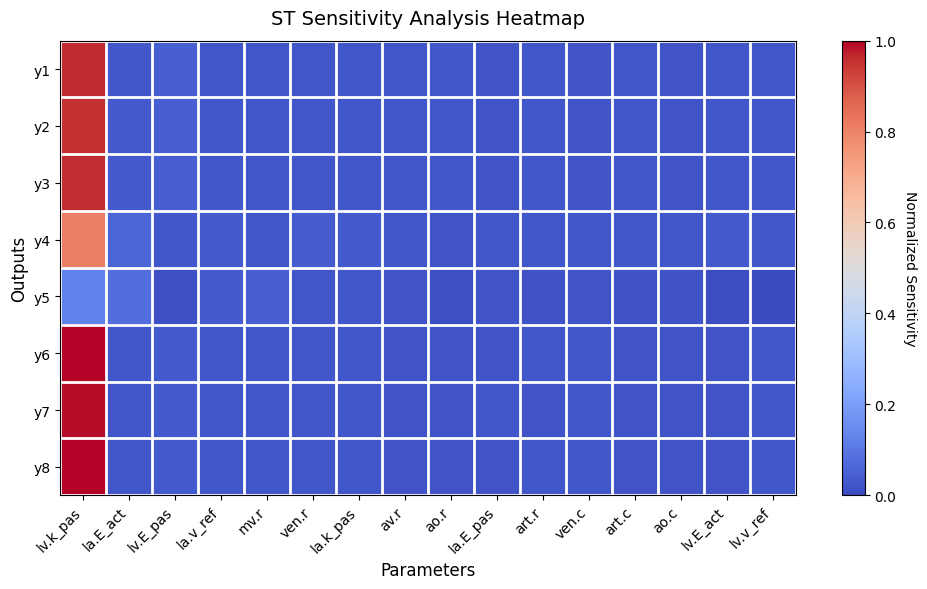

In [13]:
si.plot_sa_heatmap(si_df, index='ST', cmap='coolwarm', normalize=True, figsize=(10, 6))

We can select the top 5 parameters that have the biggest influcence on the pressure wave summary statistics extracted from the Nagavi Model.

In [14]:
top_parameters_sa = si.top_n_sobol_params(si_df,top_n=5)
top_parameters_sa

['lv.k_pas', 'la.E_act', 'lv.E_pas', 'la.v_ref', 'mv.r']

The parameters that are found to be less influential are fixed to a mid point value within its range.

In [15]:
updated_range = {}
for param_name, (min_val, max_val) in simulator.parameters_range.items():
    if param_name not in top_parameters_sa:
        print(f"Fixing parameter {param_name} to a value within its range ({min_val}, {max_val})")
        midpoint_value = (max_val + min_val) / 2.0
        updated_range[param_name] = (midpoint_value,midpoint_value)
    else:
        updated_range[param_name] = simulator.parameters_range[param_name]# Fix to a value
        

Fixing parameter ao.r to a value within its range (195.0, 325.0)
Fixing parameter ao.c to a value within its range (0.22499999999999998, 0.375)
Fixing parameter art.r to a value within its range (843.75, 1406.25)
Fixing parameter art.c to a value within its range (2.25, 3.75)
Fixing parameter ven.r to a value within its range (6.75, 11.25)
Fixing parameter ven.c to a value within its range (84.975, 141.625)
Fixing parameter av.r to a value within its range (4.5, 7.5)
Fixing parameter la.E_pas to a value within its range (0.22499999999999998, 0.375)
Fixing parameter la.k_pas to a value within its range (0.01665, 0.07500000000000001)
Fixing parameter lv.E_act to a value within its range (2.25, 3.75)
Fixing parameter lv.v_ref to a value within its range (7.5, 12.5)


In [16]:
print("Updated parameters range with fixed values for non-sensitive parameters:")
print(updated_range)
simulator.parameters_range = updated_range

Updated parameters range with fixed values for non-sensitive parameters:
{'ao.r': (260.0, 260.0), 'ao.c': (0.3, 0.3), 'art.r': (1125.0, 1125.0), 'art.c': (3.0, 3.0), 'ven.r': (9.0, 9.0), 'ven.c': (113.3, 113.3), 'av.r': (6.0, 6.0), 'mv.r': (3.0749999999999997, 5.125), 'la.E_pas': (0.3, 0.3), 'la.E_act': (0.41250000000000003, 0.6875), 'la.v_ref': (6.75, 11.25), 'la.k_pas': (0.045825000000000005, 0.045825000000000005), 'lv.E_pas': (0.75, 1.25), 'lv.E_act': (3.0, 3.0), 'lv.v_ref': (10.0, 10.0), 'lv.k_pas': (0.00999, 0.045)}


### Patient level calibration

To refine our emulator, we need real-world observations to compare against. These observations can come from experiments reported in the literature. 

In this example, we'll generate synthetic "observations" by running the simulator at the midpoint of each parameter range, treating these as our "ground truth" values for calibration. Note that in a real world example one can have multiple observations.

In [17]:
# Calculate midpoint parameters
midpoint_params_patient = []
patient_true_values = {}
for param_name in simulator.parameters_range:
    # Calculate the midpoint of the parameter range
    min_val, max_val = simulator.parameters_range[param_name]
    midpoint_params_patient.append((max_val + min_val) / 2.0)
    patient_true_values[param_name] = midpoint_params_patient[-1]

# Run the simulator with midpoint parameters
midpoint_results = simulator.forward(torch.tensor(midpoint_params_patient).reshape(1, -1))

In [18]:
# Create observations dictionary
observations = {
    name: (val.item(), max(abs(val.item()) * 0.01, 0.01)) for
    name, val in 
    zip(simulator.output_names, midpoint_results[0])}
observations


{'lv.P_min': (12.257057189941406, 0.12257057189941406),
 'lv.P_max': (24.4139347076416, 0.24413934707641602),
 'lv.P_mean': (22.56167984008789, 0.22561679840087892),
 'lv.P_range': (12.156878471374512, 0.12156878471374512)}

### History Matching

Once the influential parameters have been selected with sensitivity analysis, we want to find which values of those parameters are consistent with the clinical data for a specific patient. Rather than directly estimating the parameters, history matching first focuses on excluding regions of the parameter space that are not plausible.

AutoEmulate has the history matching workflow where we use the simulator and a fast emulator to generate model predictions for many parameter combinations.

For each simulation, 

- Compare the model output f(θ) to the observed data $y_{obs}$.  
- Compute an implausibility measure for each parameter set: $I_i(\overline{x_0}) = \frac{|z_i - \mathbb{E}(f_i(\overline{x_0}))|}{\sqrt{\text{Var}[z_i - \mathbb{E}(f_i(\overline{x_0}))]}}$
- Rule out all θ such that I(θ)>threshold (e.g., 3).

Repeat this in waves:

- After each wave, retrain the emulator on the non-implausible region (NROY).
- Stop when the NROY region changes little between waves (e.g., <10% of new points are excluded).


We now need to train a Gaussian Process emulator as we need uncertainty quantification for History Matching. Let's start generated a new dataset only sampling the most sensitive parameters and use this to train the GP emulator.

In [19]:
x = simulator.sample_inputs(N_samples,random_seed=42)
y, x = simulator.forward_batch_skip_failures(x)


Running simulations: 100%|██████████| 1.02k/1.02k [05:05<00:00, 3.35sample/s] 


In [20]:
ae_hm = AutoEmulate(
    x, 
    y, 
    models=["GaussianProcess"],  
    model_tuning=False
)

Comparing models: 100%|██████████| 1.00/1.00 [00:17<00:00, 17.6s/model]


In [21]:
from autoemulate.core.model_selection import evaluate
from autoemulate.emulators.gaussian_process.exact import GaussianProcess
from autoemulate.emulators.gaussian_process.kernel import matern_3_2_kernel
from autoemulate.transforms import *

# extract train data
x_train, y_train = ae_hm._convert_to_tensors(ae_hm.train_val)

# Create a GP and standardize x&y values (y gets standardised by default, just being explicit here for clarity)
gp_matern = GaussianProcess(
    x_train,
    y_train,
    standardize_x=True,
    standardize_y=True,
    covar_module_fn=matern_3_2_kernel
)
gp_matern.fit(x_train, y_train)

# evaluate on test data
x_test, y_test = ae_hm._convert_to_tensors(ae_hm.test)
y_pred = gp_matern.predict(x_test)
evaluate(y_pred, y_test)

0.9993770718574524

In [22]:
prediction = gp_matern.predict(x.float())


print('mean',((prediction.mean-(y))/y).mean())
print('std',((prediction.mean-y)/y).std())

print('ratio',(prediction.variance/y).mean())
print('ratio',(prediction.variance/y).std())

print('prediction variance mean', (prediction.variance/prediction.mean).mean())
print('prediction variance std', (prediction.variance/prediction.mean).std())

i=0
print (prediction.variance[i], prediction.mean[i], y[i])


mean tensor(0.0192)
std tensor(0.0449)
ratio tensor(0.0575)
ratio tensor(0.1088)
prediction variance mean tensor(0.0530)
prediction variance std tensor(0.0893)
tensor([0.5339, 0.3953, 0.4918, 0.0305]) tensor([3.0567, 8.4262, 6.7358, 5.5137]) tensor([2.6914, 8.1838, 6.3149, 5.4924])


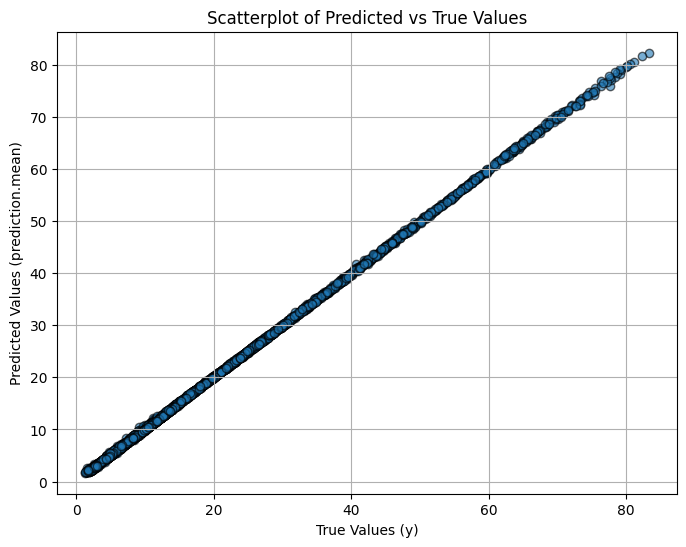

In [23]:
import matplotlib.pyplot as plt

# Scatterplot of prediction.mean vs y
plt.figure(figsize=(8, 6))
plt.scatter(y.numpy(), prediction.mean, alpha=0.6, edgecolor='k')
plt.xlabel('True Values (y)')
plt.ylabel('Predicted Values (prediction.mean)')
plt.title('Scatterplot of Predicted vs True Values')
plt.grid(True)
plt.show()

In [24]:
ae_mlp = AutoEmulate(
    x, 
    y, 
    models=["MLP"],  
    model_tuning=True
)

model_mlp = ae_mlp.best_result().model

prediction = model_mlp.predict(x.float())


print('mean',((prediction-(y))/y).mean())
print('std',((prediction-y)/y).std())


Comparing models: 100%|██████████| 1.00/1.00 [01:53<00:00, 113s/model]

mean tensor(-0.0167)
std tensor(0.0296)


Create a HistoryMatchingWorkflow object.

In [25]:
from autoemulate.calibration.history_matching import HistoryMatchingWorkflow

hmw = HistoryMatchingWorkflow(
    simulator=simulator,
    emulator=gp_matern,
    observations=observations,
    threshold=3.0,
    train_x=x.float(),
    train_y=y.float()
)

Run waves.

In [26]:
# Save the results
history_matching_results = hmw.run_waves(n_waves=6, n_simulations=N_samples, n_test_samples=1000,max_retries=1000,buffer_ratio=0)

INFO:autoemulate: Running history matching wave 1/6
DEBUG:autoemulate: Running history matching workflow with 1024 simulations and 1000 test samples.
  self.update_simulator_bounds(nroy_parameters_all, buffer_ratio)

  self.update_simulator_bounds(nroy_parameters_all, buffer_ratio)

  self.update_simulator_bounds(nroy_parameters_all, buffer_ratio)

  self.update_simulator_bounds(nroy_parameters_all, buffer_ratio)

INFO:autoemulate:Running batch simulation for 1024 samples
Running simulations: 100%|██████████| 1.02k/1.02k [05:51<00:00, 2.92sample/s] 
INFO:autoemulate:Successfully completed 1024/1024 simulations (100.0%)
INFO:autoemulate: Wave 1/6: NROY fraction is 7.59%
INFO:autoemulate: Running history matching wave 2/6
DEBUG:autoemulate: Running history matching workflow with 1024 simulations and 1000 test samples.


mean tensor(0.0012)
std tensor(0.0121)
ratio tensor(0.0087)
ratio tensor(0.0190)
prediction variance mean tensor(0.0086)
prediction variance std tensor(0.0183)
Wave  0 [[260.0, 260.0], [0.3, 0.3], [1125.0, 1125.0], [3.0, 3.0], [9.0, 9.0], [113.3, 113.3], [6.0, 6.0], [3.0769872665405273, 5.121932029724121], [0.3, 0.3], [0.4126514196395874, 0.6873623728752136], [6.7504658699035645, 11.242243766784668], [0.045825000000000005, 0.045825000000000005], [0.7500162720680237, 1.249935269355774], [3.0, 3.0], [10.0, 10.0], [0.022067714482545853, 0.032352134585380554]]


INFO:autoemulate:Running batch simulation for 1024 samples
Running simulations: 100%|██████████| 1.02k/1.02k [05:33<00:00, 3.07sample/s] 
INFO:autoemulate:Successfully completed 1024/1024 simulations (100.0%)
INFO:autoemulate: Wave 2/6: NROY fraction is 10.40%
INFO:autoemulate: Running history matching wave 3/6
DEBUG:autoemulate: Running history matching workflow with 1024 simulations and 1000 test samples.


mean tensor(0.0068)
std tensor(0.0167)
ratio tensor(0.0038)
ratio tensor(0.0100)
prediction variance mean tensor(0.0037)
prediction variance std tensor(0.0090)
Wave  1 [[260.0, 260.0], [0.3, 0.3], [1125.0, 1125.0], [3.0, 3.0], [9.0, 9.0], [113.3, 113.3], [6.0, 6.0], [3.0777571201324463, 5.11815881729126], [0.3, 0.3], [0.41459956765174866, 0.686968207359314], [6.7585530281066895, 11.229105949401855], [0.045825000000000005, 0.045825000000000005], [0.750476062297821, 1.2497575283050537], [3.0, 3.0], [10.0, 10.0], [0.02426537685096264, 0.031507931649684906]]


INFO:autoemulate:Running batch simulation for 1024 samples
Running simulations: 100%|██████████| 1.02k/1.02k [05:12<00:00, 3.27sample/s] 
INFO:autoemulate:Successfully completed 1024/1024 simulations (100.0%)
INFO:autoemulate: Wave 3/6: NROY fraction is 14.06%
INFO:autoemulate: Running history matching wave 4/6
DEBUG:autoemulate: Running history matching workflow with 1024 simulations and 1000 test samples.


mean tensor(0.0028)
std tensor(0.0081)
ratio tensor(0.0033)
ratio tensor(0.0094)
prediction variance mean tensor(0.0032)
prediction variance std tensor(0.0092)
Wave  2 [[260.0, 260.0], [0.3, 0.3], [1125.0, 1125.0], [3.0, 3.0], [9.0, 9.0], [113.3, 113.3], [6.0, 6.0], [3.079320192337036, 5.116587162017822], [0.3, 0.3], [0.4164159297943115, 0.6868897080421448], [6.760006427764893, 11.227348327636719], [0.045825000000000005, 0.045825000000000005], [0.7511268854141235, 1.2488417625427246], [3.0, 3.0], [10.0, 10.0], [0.024330124258995056, 0.031137706711888313]]


INFO:autoemulate:Running batch simulation for 1024 samples
Running simulations: 100%|██████████| 1.02k/1.02k [05:40<00:00, 3.00sample/s] 
INFO:autoemulate:Successfully completed 1024/1024 simulations (100.0%)
  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

INFO:autoemulate: Wave 4/6: NROY fraction is 13.94%
INFO:autoemulate: Running history matching wave 5/6
DEBUG:autoemulate: Running history matching workflow with 1024 simulations and 1000 test samples.


mean tensor(0.0058)
std tensor(0.0120)
ratio tensor(0.0067)
ratio tensor(0.0196)
prediction variance mean tensor(0.0066)
prediction variance std tensor(0.0191)
Wave  3 [[260.0, 260.0], [0.3, 0.3], [1125.0, 1125.0], [3.0, 3.0], [9.0, 9.0], [113.3, 113.3], [6.0, 6.0], [3.0795164108276367, 5.109567642211914], [0.3, 0.3], [0.41703230142593384, 0.6867837905883789], [6.762900352478027, 11.223938941955566], [0.045825000000000005, 0.045825000000000005], [0.7522844672203064, 1.2482213973999023], [3.0, 3.0], [10.0, 10.0], [0.024521537125110626, 0.031115923076868057]]


INFO:autoemulate:Running batch simulation for 1024 samples
Running simulations: 100%|██████████| 1.02k/1.02k [05:52<00:00, 2.91sample/s] 
INFO:autoemulate:Successfully completed 1024/1024 simulations (100.0%)
  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(



  warnings.warn(

INFO:autoemulate: Wave 5/6: NROY fraction is 15.29%
INFO:autoemulate: Running history matching wave 6/6
DEBUG:autoemulate: Running history matching workflow with 1024 simulations and 1000 test samples.


mean tensor(0.0058)
std tensor(0.0326)
ratio tensor(0.0059)
ratio tensor(0.0214)
prediction variance mean tensor(0.0058)
prediction variance std tensor(0.0225)
Wave  4 [[260.0, 260.0], [0.3, 0.3], [1125.0, 1125.0], [3.0, 3.0], [9.0, 9.0], [113.3, 113.3], [6.0, 6.0], [3.0806124210357666, 5.108551979064941], [0.3, 0.3], [0.41706985235214233, 0.6866120100021362], [6.765832901000977, 11.223084449768066], [0.045825000000000005, 0.045825000000000005], [0.7524608373641968, 1.2481917142868042], [3.0, 3.0], [10.0, 10.0], [0.024588406085968018, 0.031019046902656555]]


INFO:autoemulate:Running batch simulation for 1024 samples
Running simulations: 100%|██████████| 1.02k/1.02k [05:10<00:00, 3.30sample/s] 
INFO:autoemulate:Successfully completed 1024/1024 simulations (100.0%)
  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(



  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(



  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

INFO:autoemulate: Wave 6/6: NROY fraction is 14.16%


mean tensor(0.2169)
std tensor(0.4004)
ratio tensor(0.0047)
ratio tensor(0.0170)
prediction variance mean tensor(0.0037)
prediction variance std tensor(0.0116)
Wave  5 [[260.0, 260.0], [0.3, 0.3], [1125.0, 1125.0], [3.0, 3.0], [9.0, 9.0], [113.3, 113.3], [6.0, 6.0], [3.082357883453369, 5.104943752288818], [0.3, 0.3], [0.417572021484375, 0.6864686608314514], [6.784863471984863, 11.218120574951172], [0.045825000000000005, 0.045825000000000005], [0.7531515955924988, 1.2480714321136475], [3.0, 3.0], [10.0, 10.0], [0.02460157312452793, 0.03101840615272522]]


In [39]:
#get last values from HM
test_parameters, impl_scores = history_matching_results[-1]
nory_points = hmw.get_nroy(impl_scores,test_parameters) # Implausibility < 3.0


In [40]:
#  select indices of implausible points

plausible = []
for i in range(len(test_parameters)):
    for imp in impl_scores[i]:
        if imp <= 3.0:
            plausible.append(i)
            
            
# Select only the plausible points
test_parameters_plausible = test_parameters[plausible]
impl_scores_plausible = impl_scores[plausible]
            

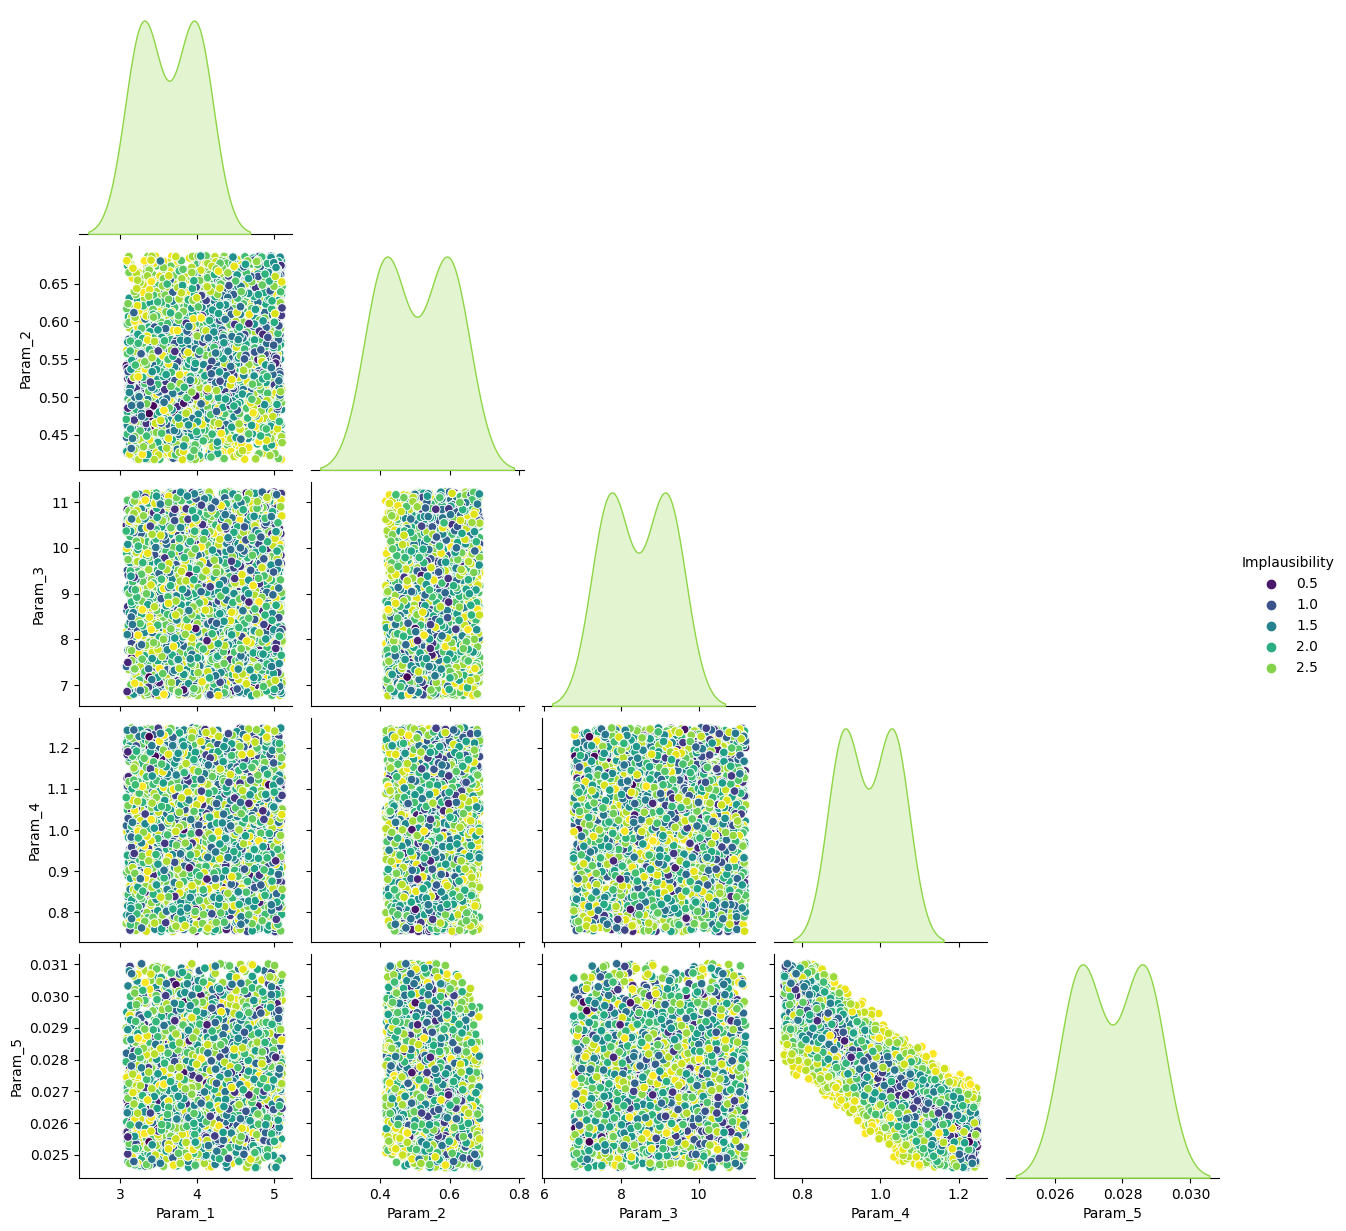

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings # To suppress some warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")


# Example data
# Replace these with your actual parameter values and plausibility scores

# Convert to a DataFrame
df = pd.DataFrame(test_parameters_plausible[:,[7,9,10,12,15]], columns=[f"Param_{i+1}" for i in range(len(test_parameters_plausible[:,[7,9,10,12,15]][0]))])
df["Implausibility"] = impl_scores_plausible.mean(axis=1)



df = df[df['Implausibility']<3]
# Create the pairplot
pairplot = sns.pairplot(df, hue="Implausibility", palette="viridis",corner=True)

# Show the plot
plt.show()

This dashboard shows the implausibility scores for each parameter combination, allowing us to visualize which regions of the parameter space are plausible (i.e., not ruled out) based on the observed data. The NROY region is highlighted, showing the parameters that remain after history matching.

In [30]:
params_post_hm = hmw.generate_param_bounds(nroy_x=nory_points,param_names=simulator.param_names)

In [31]:
for param_name, bounds in params_post_hm.items():
    
    print (f"Pre HM parameter bounds for {param_name}: {simulator.parameters_range[param_name]}")
    print (f"Post HM parameter bounds for {param_name}: {bounds}")
    


Pre HM parameter bounds for ao.r: (260.0, 260.0)
Post HM parameter bounds for ao.r: (260.0, 260.0)
Pre HM parameter bounds for ao.c: (0.3, 0.3)
Post HM parameter bounds for ao.c: (0.30000001192092896, 0.30000001192092896)
Pre HM parameter bounds for art.r: (1125.0, 1125.0)
Post HM parameter bounds for art.r: (1125.0, 1125.0)
Pre HM parameter bounds for art.c: (3.0, 3.0)
Post HM parameter bounds for art.c: (3.0, 3.0)
Pre HM parameter bounds for ven.r: (9.0, 9.0)
Post HM parameter bounds for ven.r: (9.0, 9.0)
Pre HM parameter bounds for ven.c: (113.3, 113.3)
Post HM parameter bounds for ven.c: (113.30000305175781, 113.30000305175781)
Pre HM parameter bounds for av.r: (6.0, 6.0)
Post HM parameter bounds for av.r: (6.0, 6.0)
Pre HM parameter bounds for mv.r: (3.0749999999999997, 5.125)
Post HM parameter bounds for mv.r: (2.9812285900115967, 5.206072807312012)
Pre HM parameter bounds for la.E_pas: (0.3, 0.3)
Post HM parameter bounds for la.E_pas: (0.30000001192092896, 0.30000001192092896)
P

### Bayesian calibration
With the reduced and plausible parameter space from history matching, we now perform Bayesian inference to estimate the posterior distribution of parameters given patient data. We apply the following steps:

- Define a prior over parameters using the NROY region from history matching.

- Define a likelihood function that compares model predictions to patient data, including observation and model error.

- Use a Bayesian method (MCMC) to sample from the posterior.



In [32]:
from autoemulate.calibration.bayes import BayesianCalibration

model_post_hm = hmw.emulator  # Use the emulator from history matching

bc = BayesianCalibration(
    emulator=model_post_hm,
    parameter_range=params_post_hm,
    observations = {k: torch.tensor(v[0]) for k,v in observations.items()},
    observation_noise={k: v[1] for k,v in observations.items()},
    calibration_params = top_parameters_sa
)

mcmc = bc.run_mcmc(warmup_steps=10, num_samples=10000, sampler='nuts')


INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed
INFO:autoemulate:Initializing BayesianCalibration with parameters: ['lv.k_pas', 'la.E_act', 'lv.E_pas', 'la.v_ref', 'mv.r']
DEBUG:autoemulate:Observation for output 'lv.P_min' converted from 0D to 1D.
DEBUG:autoemulate:Observation for output 'lv.P_max' converted from 0D to 1D.
DEBUG:autoemulate:Observation for output 'lv.P_mean' converted from 0D to 1D.
DEBUG:autoemulate:Observation for output 'lv.P_range' converted from 0D to 1D.
INFO:autoemulate:Processed observations for outputs: ['lv.P_min', 'lv.P_max', 'lv.P_mean', 'lv.P_range']
DEBUG:autoemulate:Observation noise set as dict: {'lv.P_min': 0.12257057189941406, 'lv.P_max': 0.24413934707641602, 'lv.P_mean': 0.22561679840087892, 'lv.P_range': 0.12156878471374512}
DEBUG:autoemulate:Using NUTS kernel.
INFO:autoemulate:Starting MCMC run.
Sample: 100%|██████████| 10010/10010 [54:47,  3.05it/s, step size=1.

In [33]:
mcmc.summary()



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  la.E_act      0.40      0.00      0.40      0.40      0.40   5150.58      1.00
  la.v_ref      7.67      0.37      7.67      7.02      8.24   7821.41      1.00
  lv.E_pas      0.73      0.00      0.73      0.73      0.73   5044.03      1.00
  lv.k_pas      0.03      0.00      0.03      0.03      0.03  10039.33      1.00
      mv.r      5.19      0.02      5.19      5.16      5.21   5529.34      1.00

Number of divergences: 0


We can check if the posterior samples are consistent with the true values of the parameters.

In [34]:
print(patient_true_values)


{'ao.r': 260.0, 'ao.c': 0.3, 'art.r': 1125.0, 'art.c': 3.0, 'ven.r': 9.0, 'ven.c': 113.3, 'av.r': 6.0, 'mv.r': 4.1, 'la.E_pas': 0.3, 'la.E_act': 0.55, 'la.v_ref': 9.0, 'la.k_pas': 0.045825000000000005, 'lv.E_pas': 1.0, 'lv.E_act': 3.0, 'lv.v_ref': 10.0, 'lv.k_pas': 0.027495}


DEBUG:autoemulate:Using az.from_pyro for conversion.
  warnings.warn(

INFO:autoemulate:Arviz InferenceData conversion complete.


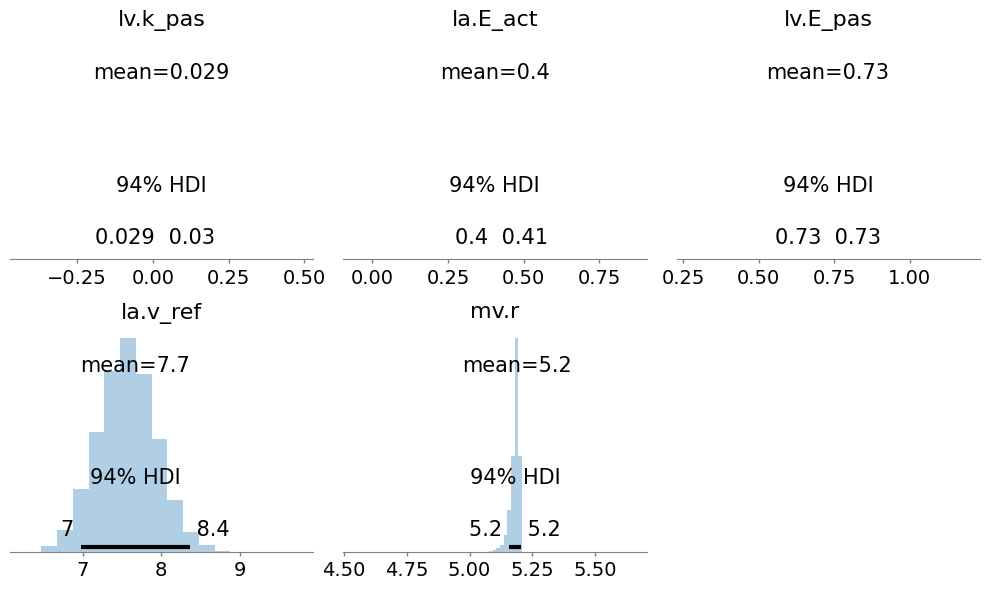

In [35]:
import arviz as az
import matplotlib.pyplot as plt
idata = bc.to_arviz(mcmc)

az.plot_posterior(idata, var_names=top_parameters_sa, kind='hist', figsize=(10, 6))
plt.tight_layout()
plt.show()
